# Estimate $n_{\beta\beta}$

Estimate the number of signal events using the extended maximum likelihood fit

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # plotting for fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objectives:

   * ***Fit the signal energy region***

### Tasks

   * Open the data file (HDF) and access the simulated data (MC) of 214Bi, 208Tl and bb0nu. 

   * Generate an experiment with a given number of signal events and a level of background compatible with the one estimated using the blind-data sample (in previous task).

   * Estimate the uncertainties in the numbe of evnets
   
### Notes

   * We are going to fit the selected events in the *erange* energy region to the three samples: $\beta\beta0\nu$, $^{214}$Bi and $^{208}$Tl.
   
   * We use an extended maximum likelihood fit of a composite PDF

## Main parameters

In [10]:
coll          = collpars.collaboration
sel_ntracks   = collpars.sel_ntracks
sel_eblob2    = collpars.sel_eblob2
sel_erange    = collpars.sel_erange
sel_eroi      = collpars.sel_eroi

print('Collaboration             : {:s}'.format(coll))
#print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
#print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
#print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
#print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta


In [13]:
# list of the analisys selection variables names and ranges
ntracks_range = (sel_ntracks, sel_ntracks + 0.1)
eblob2_range  = (sel_eblob2, sel_erange[1]) # MeV

varnames  = ['num_tracks', 'blob2_E', 'E']
varranges = [ntracks_range, eblob2_range, sel_erange]
print('ana varnames  : ', varnames)
print('ana varranges : ', varranges)

# list of the reference selction variable names and rages to get pdfs for the MC
refnames  = ['num_tracks', 'E']
refranges = [ntracks_range, sel_erange]
print('ref varnames  : ', refnames)
print('ref varranges : ', refranges)


ana varnames  :  ['num_tracks', 'blob2_E', 'E']
ana varranges :  [(1, 1.1), (0.4, 2.7), (2.4, 2.7)]
ref varnames  :  ['num_tracks', 'E']
ref varranges :  [(1, 1.1), (2.4, 2.7)]


In [20]:
# number of  blind events
n_Bi_total = collpars.n_Bi_total
n_Tl_total = collpars.n_Tl_total

eff_Bi_E   = collpars.eff_Bi_E
eff_Tl_E   = collpars.eff_Tl_E
eff_bb_E   = collpars.eff_bb_E
print('Number of bkg events in full data : Bi = {:6.2f}, Tl = {:6.2f}.'.format(n_Bi_total, n_Tl_total))

Number of bkg events in full data : Bi = 1404.20, Tl = 20659.77.


## Access the data

In [15]:
# set the path to the data directory and filenames
dirpath = rootpath+'/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

# access the simulated data (DataFrames) for the different samples (Bi, Tl, bb) located in the data file
mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

# set the names of the samples
# set the names of the samples
mc_samples         = [mcbi, mctl, mcbb] # list of the mc DFs
sample_names       = ['Bi', 'Tl', 'bb']
sample_names_latex = [ r'$^{214}$Bi', r'$^{208}$Tl', r'$\beta\beta0\nu$',] # str names of the mc samples

for i, mc in enumerate(mc_samples):
    print('MC Sample {:s}, number of simulated events = {:d}'.format(sample_names[i], len(mc)))

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2//data/fanal_new_beta.h5
MC Sample Bi, number of simulated events = 60184
MC Sample Tl, number of simulated events = 687297
MC Sample bb, number of simulated events = 47636


## Check method with a mc experiment

  * Generate a MC experiments with number of events compatible with estimated number of bkg events and a hipothetical number of signal events.
  
  * Fit the energy distribution of the selected events to the samples pdfs: bb, Bi. Tl
  
  * Do a profile scan to estimate the confidence interval and p0-value for this example
  
### Notes

  * There is an appendix with the code step by step.

### Exercises

  * Generate other experiments with different number of signal events to study the performance of the fit

In [21]:
def nevts_total(factor = 1.):
    n_Bi_RoI    = collpars.n_Bi_RoI
    eff_bb_RoI  = collpars.eff_bb_RoI
    n_Bi_total  = collpars.n_Bi_total
    n_Tl_total  = collpars.n_Tl_total
    n_bb_total  = factor * n_Bi_RoI/eff_bb_RoI
    nevts           = (n_Bi_total, n_Tl_total, n_bb_total)
    return np.array(nevts)

def nevts_in_E(nevts_total):
    eff_Bi_E    = collpars.eff_Bi_E
    eff_Tl_E    = collpars.eff_Tl_E
    eff_bb_RoI  = collpars.eff_bb_RoI
    nBi, nTl, nbb = nevts_total
    nevts       = (nBi * eff_Bi_E, nTl * eff_Tl_E, nbb * eff_bb_E)
    return np.array(nevts)

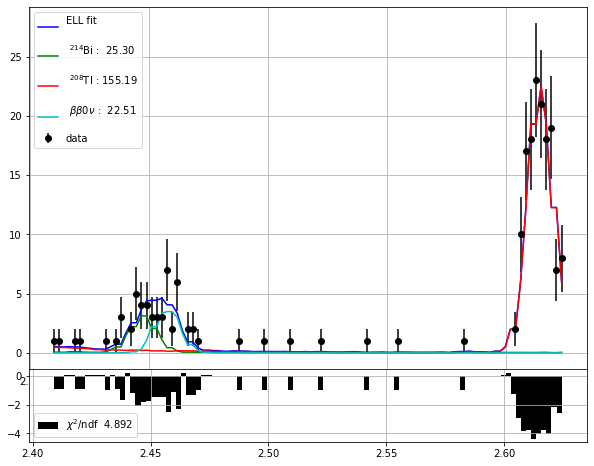

In [22]:
# set the number of events
# expected bkg events are estimated using the fit to the blind data
# consider the number of signal events a factor of the expected Bi events 
factor          = 1.
nevts_total     = nevts_total(factor)
nevts_E         = nevts_in_E(nevts_total)

# define the fit
fit             = fn.prepare_fit_ell(mc_samples, nevts_total, varnames, varranges, refnames, refranges)

# generate an experiment using the mc samples and a given number of events of each sample
mcdata          = fn.generate_mc_experiment(mc_samples, nevts_total)

result, values, \
ell, nevts_est  = fit(mcdata)
nevts_est = result.x if result.success else nevts_E

pltfn.plot_fit_ell(values, nevts_est, ell, parnames = sample_names_latex)

## Parameter uncertanties estimation

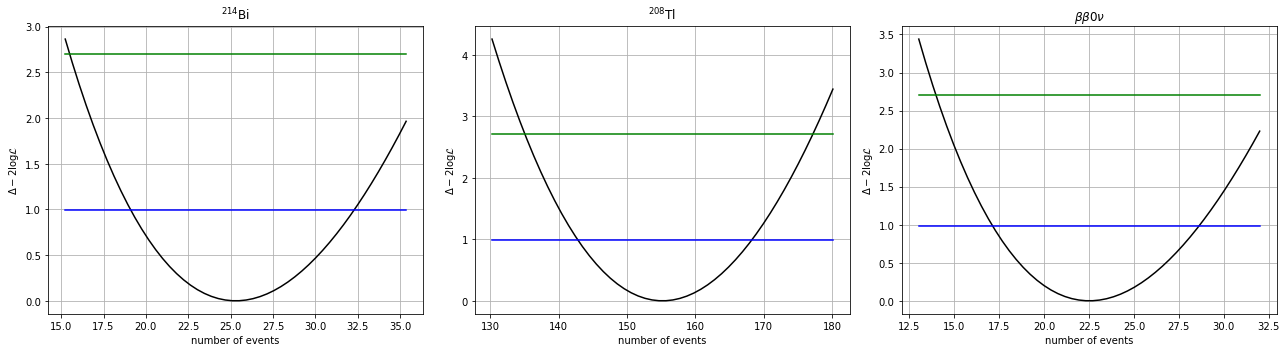

In [23]:
nis, tmus = fn.tmu_scan(values, result.x, ell, sizes = (2., 2., 2.))
pltfn.plot_tmu_scan(nis, tmus, titles = sample_names_latex)

In [25]:
cl    = 0.68
mucis = [efit.tmu_conf_int(ni, tmu, cl) for ni, tmu in zip(nis, tmus)]
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = ({:5.2f}, {:5.2f})'.format(sample_names[i], 100*cl, *ci))

Number of Bi events CI at   68 % CL = (19.34, 32.07)
Number of Tl events CI at   68 % CL = (143.49, 167.90)
Number of bb events CI at   68 % CL = (17.28, 28.51)


In [26]:
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = {:5.2f}  {:5.2f} +{:5.2f}'.format(sample_names[i], 100*cl, 
                                                                                        result.x[i],
                                                                                        *(ci - result.x[i])))

Number of Bi events CI at   68 % CL = 25.30  -5.95 + 6.77
Number of Tl events CI at   68 % CL = 155.19  -11.69 +12.71
Number of bb events CI at   68 % CL = 22.51  -5.23 + 6.00


## Null hypothesis p-value calculation

In [27]:
q0 = efit.tmu(values, ell, result.x, 0.)
z0 = np.sqrt(q0)
p0 = 1 - stats.norm.cdf(z0)
#p0 = stats.chi2.sf(q0, 1)/2.
print('H0 p value {:1.2e}, {:4.2f} sigmas'.format(p0, z0))

H0 p value 9.55e-09, 5.62 sigmas


## Estimate the half-time

In [29]:
from collpars import exposure

eff      = collpars.acc_bb * collpars.eff_bb_E
n_bb_E   = nevts_est[-1]
tau      = fn.half_life(n_bb_E, exposure, eff)

print('number of bb0nu events in E  : {:6.3f}'.format(n_bb_E))
print('exposure                     : {:6.2f} kg y'.format(exposure))
print('total signal efficiency      : {:6.3f}'.format(eff))
print('bb0nu half-life              : {:6.2e} y '.format(tau))

number of bb0nu events in E  : 22.508
exposure                     : 1000.00 kg y
total signal efficiency      :  0.410
bb0nu half-life              : 5.04e+25 y 


## Appendix: Step by step

In [30]:
# set the number of events
# expected bkg events are estimated using the fit to the blind data
# consider the number of signal events a factor of the expected Bi events 
factor          = 1.
nevts           = nevts_total(factor)

# generate the ELL instace to fit the energy distribution to the energy distribution of the three mc samples
ell             = fn.get_ell(mc_samples, refnames, refranges)

# expected number of events for each mc sample
effs            = [ut.selection_efficiency(mc, varnames, varranges)[0] for mc in mc_samples]
nevts_exp       = effs * np.array(nevts)

# generate an experiment using the mc samples and a given number of events of each sample
mcdata          = fn.generate_mc_experiment(mc_samples, nevts)

# select the data
datana          = ut.selection_sample(mcdata, varnames, varranges)

# fit the energy values of the data 
values          = datana['E'].values
result          = ell.best_estimate(values, *nevts_exp)
nevts_est       = result.x

# plot the results
pltfn.plot_fit_ell(values, nevts_est, ell)

# print out
print('Total number of events     :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(samples_name, nevts)])
print('Expected number of events  :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(samples_name, nevts_exp)])

print('Fit success ?              :', result.success)
print('Estimated number of events :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(samples_name, nevts_est)])

TypeError: 'numpy.ndarray' object is not callable